In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import widgets, Layout
from IPython.display import display,clear_output

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
from import_casa import casa
font = FontProperties(fname=casa.get_data_path() / "font/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = "Microsoft YaHei" 

In [4]:
from casa import Cadet

In [5]:
cadet = Cadet.load(casa.get_data_path()/"cadet/op20")
cadet

[INFO] 2021-01-28 12:57:16,931 gensim.utils: loading Word2VecKeyedVectors object from /Users/seantyh/langon/casa/data/cadet/op20/ft-2020.kv
[INFO] 2021-01-28 12:57:17,207 gensim.utils: setting ignored attribute vectors_norm to None
[INFO] 2021-01-28 12:57:17,208 gensim.utils: setting ignored attribute vectors_vocab_norm to None
[INFO] 2021-01-28 12:57:17,208 gensim.utils: setting ignored attribute vectors_ngrams_norm to None
[INFO] 2021-01-28 12:57:17,209 gensim.utils: setting ignored attribute buckets_word to None
[INFO] 2021-01-28 12:57:17,209 gensim.utils: loaded /Users/seantyh/langon/casa/data/cadet/op20/ft-2020.kv
[INFO] 2021-01-28 12:57:17,209 gensim.models.keyedvectors: precomputing L2-norms of word weight vectors
[INFO] 2021-01-28 12:57:17,216 gensim.models.keyedvectors: precomputing L2-norms of ngram weight vectors


<Cadet: FastText(9851, 200), Seeds(103)>

In [6]:
data = cadet.detect("中華電信吃到飽很快")
data

{'entity': ['中華電信', '台灣大哥大', '遠傳電信', '台灣之星', '亞太電信', '其他電信'],
 'entity_probs': array([0.94104001, 0.01306771, 0.01242239, 0.01155992, 0.0118678 ,
        0.01004217]),
 'service': ['資費方案', '通訊品質', '加值服務', '其他'],
 'service_probs': array([0.96569904, 0.01162185, 0.01281314, 0.00986597]),
 'seeds': ['吃到飽', '大4G', '方案', '轉4G', '升級4G'],
 'seed_probs': array([0.5145627 , 0.00778411, 0.00764274, 0.00757279, 0.00757279])}

In [7]:
def plot_detect_data(data, axes):       
    plt.ioff()
    plt.subplots_adjust(wspace=0.5)
    axes[0].barh(np.arange(len(data["entity"])), data["entity_probs"])
    axes[0].set_yticks(np.arange(len(data["entity"])))
    axes[0].set_yticklabels(data["entity"], fontproperties=font)
    axes[0].set_xlabel("probs")
    axes[0].set_xlim([0, 1.1])
    axes[1].barh(np.arange(len(data["service"])), 
                 data["service_probs"])
    axes[1].set_yticks(np.arange(len(data["service"])))
    axes[1].set_yticklabels(data["service"], fontproperties=font)
    axes[1].set_xlabel("probs")
    axes[1].set_xlim([0, 1.1])
    plt.setp(axes[0].get_yticklabels(), Fontsize=14)
    plt.setp(axes[1].get_yticklabels(), Fontsize=14) 

/Users/seantyh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app
/Users/seantyh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()
[WARNING] 2021-01-28 12:57:17,417 matplotlib.font_manager: findfont: Font family ['Microsoft YaHei'] not found. Falling back to DejaVu Sans.


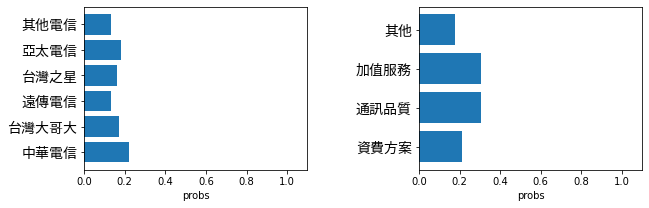

In [8]:
data = cadet.detect("武漢肺炎篩檢好貴")
fig, axes = plt.subplots(1, 2, figsize=(10,3))
_ = plot_detect_data(data, axes);


In [9]:
button = widgets.Button(description="偵測")
textbox = widgets.Text(description="測試文句", value="中華的吃到飽很快", layout=Layout(width="500px"))
input_widgets = widgets.HBox([textbox, button])
keyword_label = widgets.Label(value="服務關鍵詞：" + " ".join(data["seeds"]))
outbox = widgets.Output(layout=widgets.Layout(height='400px', width='600px'))
layout = widgets.VBox([
    input_widgets, keyword_label, outbox
    ])

def click(ev):    
    plt.ioff()
    data = cadet.detect(textbox.value)
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    plot_detect_data(data, axes);
    keyword_label.value = "服務關鍵詞：" + " ".join(data["seeds"])
    with outbox:
        clear_output(wait=True)
        display(fig)

display(layout)
click(None);
button.on_click(click)
plt.close()

/Users/seantyh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app
/Users/seantyh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  app.launch_new_instance()


## The Service Aspect Detection Module

A SentencePiece model is first trained on all the texts in the corpus. The texts are tokenzied with the trained model, and the resulting tokens, which are composed of 9851 unique tokens, are the input of a downstream FastText model. The FastText model is trained with hidden dimension of 200, window size of 10, and bucket size of 30K. 

To detect the relevant service aspects, the module requires a seed lexicon. The seed lexicon is first generated with the FastText model along with a predefined seed list. The FastText model produces the most similar 20 candidates words (SentencePiece tokens) for each seed. Afterward, an editor manully revises the content to ensure only relevant candidates entered the lexicon.  

All three components: SentencePiece model, FastText model and seed lexicon, work together in the service detection. The input text is first tokenized with SentencePiece, and each tokens are projected into embedding space with FastText. Each token embeddings are compared with the seeds' embeddings, which are also provided by the FastText, to compute similarity scores. These scores are then transformed and softmaxed into probability distribution of categories.

$$
\begin{align}
\textrm{sentence} & = (t_1, t_2, \ldots, t_n)\\
\textrm{seeds} & = (w_1, w_2, \ldots, w_q)\\
v_i & = \textrm{embedding}(t_i), \textrm{token embeddings, which have $d$ dimensions} \\
\phi_j &= \textrm{embedding}(w_j), \textrm{seed candidates embeddings. There are $q$ candidates under $p$ seeds} \\
T &= [v_1; v_2; \ldots; v_n], \textrm{tokens matrix, (n x d)} \\
C &= [\phi_1; \phi_2; \ldots; \phi_q], \textrm{candidates matrix, (q x d)} \\
M &= T \cdot C^{\top}, \textrm{token-candidate similarity matrix, (n x q)} \\
Z &= \textrm{aggregate}(M), \textrm{token-seed similarity matrix, aggregate candidates under the same seeds, (n x p)} \\
V &= \textrm{collapse}(Z), \textrm{seed score vector, collapse candidates similarity along the token axis, (p,1)} \\
p(\textrm{entity}) &= \textrm{softmax-transform}(V_{\textrm{entity}}) \\
p(\textrm{service}) &= \textrm{softmax-transform}(V_{\textrm{service}}) \\
p(\textrm{seed}) &= \textrm{softmax-transform}(V_{\textrm{seed}}) \\
\end{align}
$$

## Seed embeddings

In [25]:
w1 = "不限速吃到飽、4G吃到飽、5G吃到飽、上網吃到飽、499吃到飽、不降速、限速".split("、")
w2 = "繳費、悠遊卡、銀行、信用卡、帳單、加值、現金、費用、聯名卡".split("、")
w3 = "網速、覆蓋率、高速、頻寬、3G、很慢、涵蓋、測速、滿格、品質、連線".split("、")
wv = cadet.kv
words = w1+w2+w3
wclasses = [1]*len(w1) + [2]*len(w2) + [3]*len(w3)
wvecs = np.vstack([wv.get_vector(w) for w in words])

In [26]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(2)
wv2d = pca.fit_transform(wvecs)

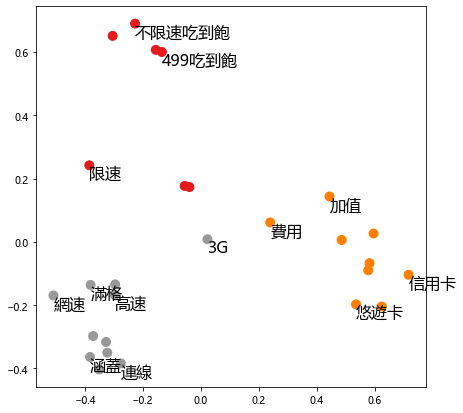

In [28]:
_, axes = plt.subplots(1, 1, figsize=(7,7))
plt.scatter(wv2d[:,0], wv2d[:,1], c=wclasses, s=80, cmap="Set1")
flag = True
for i in range(wvecs.shape[0]):
    if i % 2 != 0: continue
    if words[i].startswith("5G"): continue
    va_val = "top" if flag else "bottom"
    axes.annotate(words[i], (wv2d[i][0], wv2d[i][1]), 
                  fontsize=16, va=va_val)
    flag = !flag